In [89]:
import pymysql as pq
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline
connection=pq.connect('127.0.0.1','root','v24565812','kaggle-demo')

sql="select *from bike_train"

df = pd.read_sql(sql, con=connection)
connection.close()

In [90]:
df.head()
#datetime - hourly date + timestamp
#season - 1 = spring, 2 = summer, 3 = fall, 4 = winter
#holiday - whether the day is considered a holiday
#workingday - whether the day is neither a weekend nor holiday
#weather -
#1: Clear, Few clouds, Partly cloudy, Partly cloudy  少雲
#2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  有霧
#3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 小雨/雪
#4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 暴雨/雪
#temp - temperature in Celsius 
#atemp - "feels like" temperature in Celsius 體感溫度
#humidity - relative humidity 相對濕度
#windspeed - wind speed
#casual - number of non-registered user rentals initiated 未註冊
#registered - number of registered user rentals initiated 有註冊
#count - number of total rentals (Dependent Variable)  總租量

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,1,1


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null int64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(2), int64(9), object(1)
memory usage: 1020.6+ KB


In [92]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799100,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164634,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.000000,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,13.000000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,17.000000,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,57.000000,367.000000,886.000000,977.000000


In [97]:
df["date"] = df.datetime.apply(lambda x : x.split()[0])
df["hour"] = df.datetime.apply(lambda x : x.split()[1].split(":")[0])
df["year"] = df.datetime.apply(lambda x : x.split()[0].split("-")[0])
df=df.drop(['datetime'],axis=1)

從count的圖中可發現，有非常多的outlier的狀況。
而從count與season的圖中可發現在春季時租用數量相對較低
觀察一整日每個小時的租用時間可發現，租用數量的高峰早上7、8點及晚上5、6點的時段。
而從工作日及非工作日中的數量差距不大，但產生outliter較多是來自工作日。

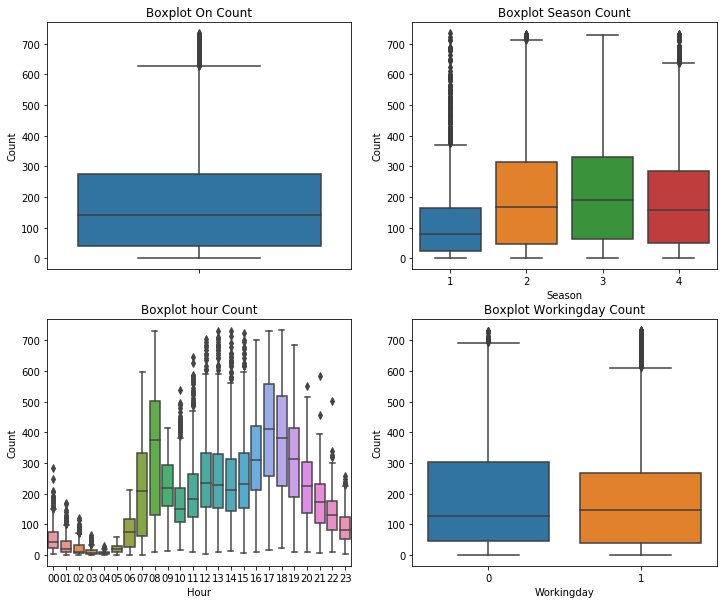

In [104]:
fig, axx = plt.subplots(2,2,figsize=(12,10))
sn.boxplot(data=df,y="count",ax=axx[0][0])
sn.boxplot(data=df,y="count",x='season',ax=axx[0][1])
sn.boxplot(data=df,y="count",x='hour',ax=axx[1][0])
sn.boxplot(data=df,y="count",x='workingday',ax=axx[1][1])

axx[0][0].set(ylabel='Count',title="Boxplot On Count")
axx[0][1].set(ylabel='Count',xlabel='Season',title="Boxplot Season Count")
axx[1][0].set(ylabel='Count',xlabel='Hour',title="Boxplot hour Count")
axx[1][1].set(ylabel='Count',xlabel='Workingday',title="Boxplot Workingday Count")
plt.show()

In [99]:
#將outliter(離群值)剃除
print('shape before ouliers:',df.shape)
df =df[np.abs(df["count"]-df["count"].mean())<=(3*df["count"].std())] 
print('shape after ouliers:',df.shape)

shape before ouliers: (10886, 14)
shape after ouliers: (10739, 14)


為了解各個變數間的相關性，選定了了"temp","atemp","humidity","windspeed","count","casual","registered"，來看其相關係數。
從圖中能發現temp與atemp間有非常高的相關性(0.99),因此我們只需選擇temp來使用。
windsspeed與各個變數的相關性皆非常低。
而casual與registered屬於 leakage變數，因此也不在考量範圍內。

因此我們選定 temp,humidity,windspeed 在進行觀察

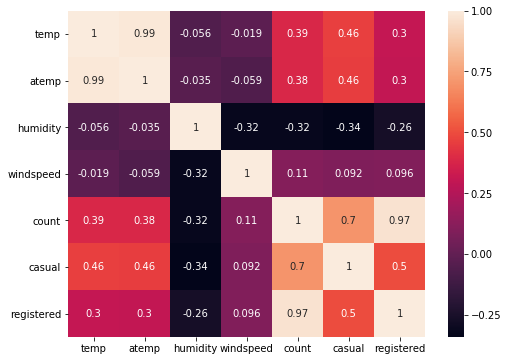

In [83]:
fig,axa =plt.subplots(1,1,figsize=(8,6))
sn.heatmap(df.loc[:,["temp","atemp","humidity","windspeed","count","casual","registered"]].corr(),
           annot=True,)
plt.show()

從最右圖中可發現，windspeed數據中0值的數據非常的多，並且可發現在接近0值到風速6、7之間皆沒有任何數據，因此可推斷風速過小的情況是無法測量的，其直接被補上為0，而0值過多會造成模型預估

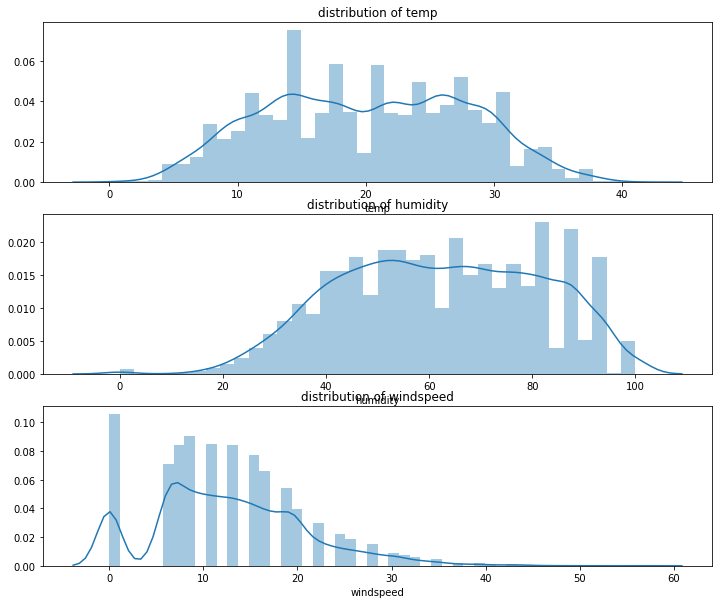

In [100]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3)
fig.set_size_inches(12, 10)
sn.distplot(df["temp"],ax=ax1)
sn.distplot(df["humidity"],ax=ax2)
sn.distplot(df["windspeed"],ax=ax3)

ax1.set(xlabel='temp',title="distribution of temp")
ax2.set(xlabel='humidity',title="distribution of humidity")
ax3.set(xlabel='windspeed',title="distribution of windspeed")
plt.show()

因風速0值過多，可能造成模型偏誤，因此將風速分為0值與非0值
再使用不為0的資料勳練RandomForest模型，在進一步淤測風速為0時，其真正值為多少。

In [101]:
dataWind0 = df[df["windspeed"]==0]
dataWindNot0 = df[df["windspeed"]!=0]
rfModel_wind = RandomForestRegressor()
windColumns = ["season","weather","humidity","temp","year",]
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])

wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])
dataWind0["windspeed"] = wind0Values
df = dataWindNot0.append(dataWind0)
df.reset_index(inplace=True)
df.drop('index',inplace=True,axis=1)

c:\users\qq\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\qq\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


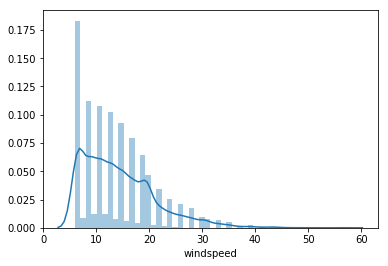

In [103]:
#填補後之風速值
sn.distplot(df["windspeed"])
plt.show()

最後觀察count值分布，可看出資料有偏斜情況，為了讓他更符合常態分布，因此將其直取LOG。

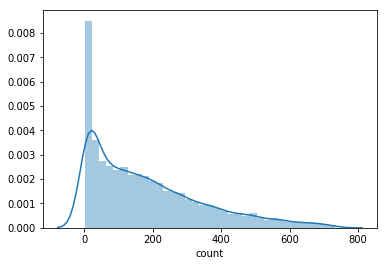

In [85]:
sn.distplot(df['count'])

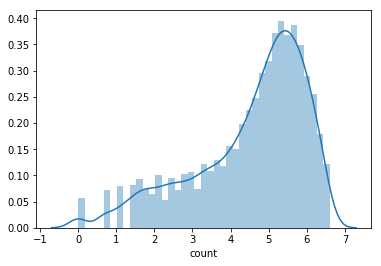

In [105]:
#取LOG後之分布圖
x=df['count']
ylog=np.log(x)
sn.distplot(ylog)

In [110]:
rfModel = RandomForestRegressor(n_estimators=1000,random_state=42)
X=['season','holiday','workingday','weather','year','hour','temp','humidity','windspeed']
rfModel.fit(df[X],ylog)
preds = rfModel.predict(X= df[X])
rfModel.score(df[X],ylog)

0.9914560877309928